# astropy.coordinates

---

## 1. Convert a radial velocity to the Galatic Standard of Rest(GSR)

Radial or line-of-sight velocities of sources are often reported in a Heliocentric or Solar-system barycentric reference frame. A common transformation incorporates the projection of the Sun’s motion along the line-of-sight to the target, hence transforming it to a Galactic rest frame instead (sometimes referred to as the Galactic Standard of Rest, GSR). This transformation depends on the assumptions about the orientation of the Galactic frame relative to the bary- or Heliocentric frame. It also depends on the assumed solar velocity vector. Here we’ll demonstrate how to perform this transformation using a sky position and barycentric radial-velocity.

By: Adrian Price-Whelan

License: BSD

1. 필요 패키지 불러오기

In [1]:
import astropy.coordinates as coord
import astropy.units as u

Use the latest convention for the Galactocentric coordinates

In [3]:
coord.galactocentric_frame_defaults.set('latest')

<ScienceState galactocentric_frame_defaults: {'galcen_coord': <ICRS Coordinate: (ra, dec) in deg...>

For this example, let’s work with the coordinates and barycentric radial velocity of the star HD 155967, as obtained from Simbad:

In [4]:
icrs = coord.SkyCoord(ra = 258.58356362*u.deg, dec = 14.55255619*u.deg,
                      radial_velocity = -16.1*u.km/u.s, frame = 'icrs')

We next need to decide on the velocity of the Sun in the assumed GSR frame. We’ll use the same velocity vector as used in the Galactocentric frame, and convert it to a CartesianRepresentation object using the `.to_cartesian()` method of the CartesianDifferential object `galcen_v_sun`:

In [5]:
v_sun = coord.Galactocentric().galcen_v_sun.to_cartesian()

We now need to get a unit vector in the assumed Galactic frame from the sky position in the ICRS frame above. We’ll use this unit vector to project the solar velocity onto the line-of-sight:



In [7]:
gal = icrs.transform_to(coord.Galactic)
cart_data = gal.data.to_cartesian()
unit_vector = cart_data / cart_data.norm()

Now we project the solar velocity using this unit vector:

In [8]:
v_proj = v_sun.dot(unit_vector)

Finally, we add the projection of the solar velocity to the radial velocity to get a GSR radial velocity:

In [9]:
rv_gsr = icrs.radial_velocity + v_proj
print(rv_gsr)

123.3046008737976 km / s


We could wrap this in a function so we can control the solar velocity and re-use the above code:

In [12]:
# convert function definition


def rv_to_gsr(c, v_sun = None):
    """ Transform a barycentric radial velocity to the Galatic Standard of Rest(GSR).
    
    The input radial velocity must be passed in as a 
    
    parameters 
    ----------
    c: '~astropy.coordinates.BaseCoordinateFrame' subclass instance
        The radial velocity, associated with a sky coordinates, to be transformed.
    v_sun: '~astropy.units.Quantity', optional 
        The 3D velocity of the solar system barycenter in the GSR frame.
        Defaults to the same solar motion as in the '~astropy.coordinates.Galactocentric' frame.
        
    Returns 
    -------
    v_gsr: 'astropy.units.Quantity'
            The input radial velocity transformed to a GSR frame.

    """
    
    if v_sun is None:
        v_sun = coord.Galactocentric().galcen_v_sun.to_cartesian()
        
    gal = c.transform_to(coord.Galactic)
    cart_data = gal.data.to_cartesian()
    unit_vector = cart_data / cart_data.norm()
    
    v_proj = v_sun.dot(unit_vector)
    
    return c.radial_velocity + v_proj



In [13]:
rv_gsr = rv_to_gsr(icrs)
print(rv_gsr)

123.3046008737976 km / s


---

## 2. Determinig and plotting the altitude(고도)/azimuth(방위각) of a celestial object

This example demonstrates coordinate transformations and the creation of visibility curves to assist with observing run planning.

In this example, we make a SkyCoord instance for `M33`. The altitude-azimuth coordinates are then found using astropy.coordinates.EarthLocation and astropy.time.Time objects.

![M33](pictures_ref/M33.png)

This example is meant to demonstrate the capabilities of the astropy.coordinates package. For more convenient and/or complex observation planning, consider the astroplan package.

By: Erik Tollerud, Kelle Cruz

License: BSD

Let’s suppose you are planning to visit picturesque Bear Mountain State Park in New York, USA. You’re bringing your telescope with you (of course), and someone told you M33 is a great target to observe there. You happen to know you’re free at 11:00 pm local time, and you want to know if it will be up. Astropy can answer that.

Import numpy and matplotlib. For the latter, use a nicer set of plot parameters and set up support for plotting/converting quantities.

In [31]:
# 필요 패키지 불러오기
import matplotlib.pyplot as plt
import numpy as np

from astropy.visualization import astropy_mpl_style, quantity_support

plt.style.use(astropy_mpl_style)
quantity_support()

import astropy.units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord
from astropy.time import Time

astropy.coordinates.SkyCoord.from_name uses Simbad to resolve object names and retrieve coordinates.

Get the coordinates of M33:

In [3]:
m33 = SkyCoord.from_name('M33')
print(m33)

<SkyCoord (ICRS): (ra, dec) in deg
    (23.46206906, 30.66017511)>


Use astropy.coordinates.EarthLocation to provide the location of Bear Mountain and set the time to 11pm EDT on 2012 July 12:

In [26]:
bear_mountain = EarthLocation(lat = 41.3*u.deg, lon = -74*u.deg, height = 390*u.m)
utcoffset = -4*u.hour
time = Time('2012-7-12 23:00:00') - utcoffset

print(time)

2012-07-13 03:00:00.000


In [13]:
# time offset 확인
import datetime

tmp_time = datetime.datetime.now(datetime.timezone.utc)
print(tmp_time.strftime('%Y-%m-%d %H:%M:%S'), "\n")
print(tmp_time.astimezone().strftime('%Y-%m-%d %H:%M:%S'), "\n")
print(tmp_time.astimezone().strftime('%Y-%m-%d %H:%M:%S %Z'), "\n")
print(tmp_time.astimezone().strftime('%Y-%m-%d %H:%M:%S %z'), "\n")

2023-01-26 07:26:29 

2023-01-26 16:26:29 

2023-01-26 16:26:29 대한민국 표준시 

2023-01-26 16:26:29 +0900 



astropy.coordinates.EarthLocation.get_site_names and get_site_names can be used to get locations of major observatories.

Use astropy.coordinates to find the Alt, Az coordinates of M33 at as observed from Bear Mountain at 11pm on 2012 July 12.

In [24]:
m33altaz = m33.transform_to(AltAz(obstime = time, location = bear_mountain))
print(f"M33's Altitude = {m33altaz.alt:.2}")
print(f"M33's Azimuth = {m33altaz.az:.2}")

M33's Altitude = 0.13 deg
M33's Azimuth = 4.7e+01 deg


This is helpful since it turns out M33 is barely above the horizon at this time. It’s more informative to find M33’s airmass over the course of the night.

Find the alt,az coordinates of M33 at 100 times evenly spaced between 10pm and 7am EDT:

This is helpful since it turns out M33 is barely above the horizon at this time. It’s more informative to find M33’s airmass over the course of the night.

Find the alt,az coordinates of M33 at 100 times evenly spaced between 10pm and 7am EDT(Eastern Daylight Time):

In [32]:
midnight = Time('2012-7-13 00:00:00') - utcoffset
                
delta_midnight = np.linspace(-2, 10, 100)*u.hour

frame_July13night = AltAz(obstime = midnight + delta_midnight,
                          location = bear_mountain)

m33altazs_July13night = m33.transform_to(frame_July13night)
                
                
# convert alt, az to airmass with secz attribute:

m33airmass_July13night = m33altazs_July13night.secz

Plot the airmass as a function of time:

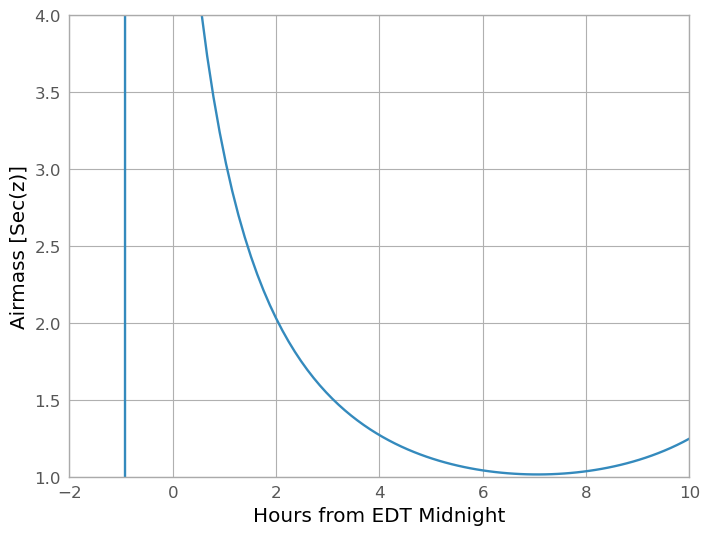

In [33]:
plt.plot(delta_midnight, m33airmass_July13night)
plt.xlim(-2, 10)
plt.ylim(1, 4)
plt.xlabel('Hours from EDT Midnight')
plt.ylabel('Airmass [Sec(z)]')
plt.show()

Use get_sun to find the location of the Sun at 1000 evenly spaced times between noon on July 12 and noon on July 13:

In [40]:
from astropy.coordinates import get_sun 

delta_midnight = np.linspace(-12, 12, 1000)*u.hour
# print(delta_midnight)

In [35]:
times_July12_to_13 = midnight + delta_midnight
frame_July12_to_13 = AltAz(obstime = times_July12_to_13, location = bear_mountain)
sunaltazs_July12_to_13 = get_sun(times_July12_to_13).transform_to(frame_July12_to_13)

Do the same with get_moon to find when the moon is up. Be aware that this will need to download a 10MB file from the internet to get a precise location of the moon.

In [36]:
from astropy.coordinates import get_moon

moon_July12_to_13 = get_moon(times_July12_to_13)
moonaltazs_July12_to_13 = moon_July12_to_13.transform_to(frame_July12_to_13)

Find the alt,az coordinates of M33 at those same times:

In [37]:
m33altazs_July12_to_13 = m33.transform_to(frame_July12_to_13)

Make a beautiful figure illustrating nighttime and the altitudes of M33 and the Sun over that time:

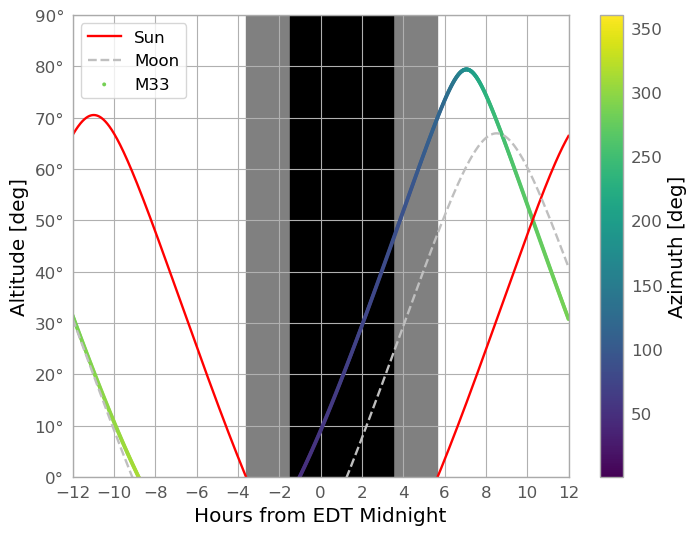

In [39]:
plt.plot(delta_midnight, sunaltazs_July12_to_13.alt, color = 'r', label = 'Sun')
plt.plot(delta_midnight, moonaltazs_July12_to_13.alt, color = [0.75]*3, ls = '--', label = 'Moon')
plt.scatter(delta_midnight, m33altazs_July12_to_13.alt,
            c = m33altazs_July12_to_13.az, 
            label = 'M33',
            lw = 0,
            s = 8,
            cmap = 'viridis')

plt.fill_between(delta_midnight, 0*u.deg, 90*u.deg,
                 sunaltazs_July12_to_13.alt < -0*u.deg, color = '0.5', zorder = 0)
plt.fill_between(delta_midnight, 0*u.deg, 90*u.deg,
                 sunaltazs_July12_to_13.alt < -18*u.deg, color = 'k', zorder = 0)
plt.colorbar().set_label('Azimuth [deg]')
plt.legend(loc = 'upper left')
plt.xlim(-12*u.hour, 12*u.hour)
plt.xticks((np.arange(13)*2 - 12)*u.hour)
plt.ylim(0*u.deg, 90*u.deg)
plt.xlabel('Hours from EDT Midnight')
plt.ylabel('Altitude [deg]')
plt.show()

---
## **(번외)** 조경철 천문대 기준 대기량(airmass) 시각화 및 시상 예측

- **대기량(airmass)**은 천문학에서 천체의 빛이 지구 대기권을 통과하면서 그리는 광학적 거리

> 빛이 지나가는 대기의 양이 많을수록, 소광이 더 크게 일어나 같은 천체라도 지평선 근처에 있을 때 천정 근처에 있을 때보다 어두워진다. 소광은 비어-람베르트 법칙을 통해 정량적으로 기술됨

> 대기량의 정의에 의해 해수면에서 천정까지의 대기량은 1이고, 천정과 천체 사이의 각도가 커질수록(즉 고도가 낮아질수록) 증가해 지평선 근처에서는 약 38이됨

> $ h = 90^{\circ} - z $

> $ X = sec(z) = \frac{1}{cos(z)}$


In [51]:
from astropy.coordinates import solar_system_ephemeris

from astropy.coordinates import get_body

In [52]:
solar_system_ephemeris.bodies

('earth',
 'sun',
 'moon',
 'mercury',
 'venus',
 'earth-moon-barycenter',
 'mars',
 'jupiter',
 'saturn',
 'uranus',
 'neptune')

In [160]:
# 조경철 천문대 타임 생성

ckc_obs = EarthLocation(lat = 38.118612*u.deg, lon = 127.433975*u.deg, height = 1010*u.m)
UTC_offset_KST = 9*u.hour # KST offset

# tmp_time = datetime.datetime.now(datetime.timezone.utc)
# time_now = tmp_time.strftime('%Y-%m-%d %H:%M:%S')
# print(time_now)

2023-01-26 09:31:21


In [145]:
# 현재 시간 출력하기

# time_ckc_UTC = Time('2023-1-26 23:00:00') - UTC_offset_KST
# time_ckc_UTC = Time(time_now) - UTC_offset_KST
# print(time_ckc_UTC)

2023-01-26 00:19:25.000


In [199]:
# time_now (UTC) 타임으로 obstime 설정 시 이상없이 들어옴
tmp_time = datetime.datetime.now(datetime.timezone.utc)
time_now = tmp_time.strftime('%Y-%m-%d %H:%M:%S')

mars = get_body('mars', time = Time(time_now), location = ckc_obs)
mars_at_ckc = mars.transform_to(AltAz(obstime = Time(time_now), location = ckc_obs))
print(f"Mars's Altitude = {mars_at_ckc.alt:.2}")
print(f"Mars's Azimuth = {mars_at_ckc.az:.2}")

Mars's Altitude = 6.9e+01 deg
Mars's Azimuth = 1.2e+02 deg


In [208]:
# 특정일의 자정을 기점으로 분석해 보기 

midnight_ckc = Time('2023-1-27 00:00:00') - UTC_offset_KST
    
# delta_midnight_ckc = np.linspace(-6, 6, 100)*u.hour
delta_midnight_ckc2 = np.linspace(-12, 12, 1000)*u.hour

frame_tonight = AltAz(obstime = midnight_ckc + delta_midnight_ckc2,
                      location = ckc_obs)

mars_tonight = mars.transform_to(frame_tonight)

airmass_mars_tonight = mars_tonight.secz

# print(delta_midnight_ckc)
# print(frame_tonight)
# print(mars_tonight)

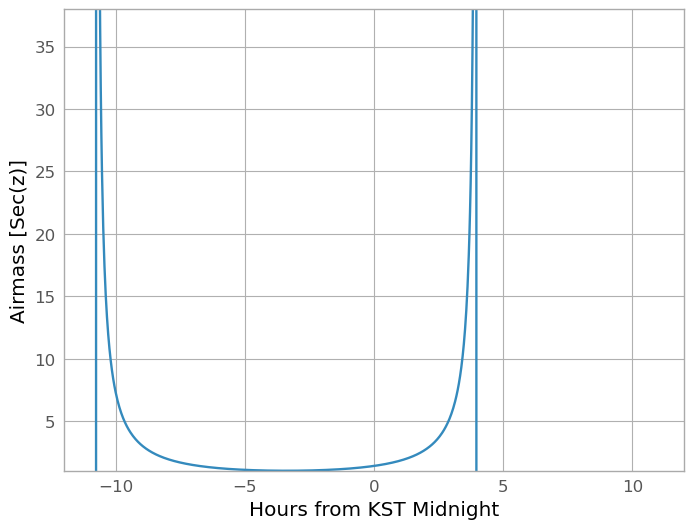

In [209]:
# convert alt, az to airmass with secz attribute:
plt.plot(delta_midnight_ckc2, airmass_mars_tonight)
plt.xlim(-12, 12)
plt.ylim(1, 38)
plt.xlabel('Hours from KST Midnight')
plt.ylabel('Airmass [Sec(z)]')
plt.show()

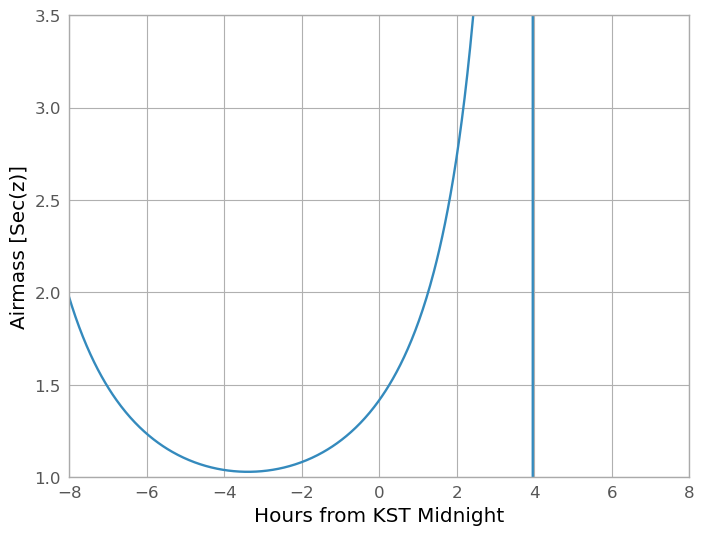

In [210]:
plt.plot(delta_midnight_ckc2, airmass_mars_tonight)
plt.xlim(-8, 8)
plt.ylim(1, 3.5)
plt.xlabel('Hours from KST Midnight')
plt.ylabel('Airmass [Sec(z)]')
plt.show()

In [212]:
airmass_max_time = Time('2023-1-27 00:00:00') - delta_midnight_ckc2[np.argmin(airmass_mars_tonight)]

print(airmass_max_time)

2023-01-26 20:01:26.486


In [189]:
# 태양 고도 생성하기 
from astropy.coordinates import get_sun 

# midnight_ckc2 = Time('2023-1-26 00:00:00') + utcoffset_KST
delta_midnight_ckc2 = np.linspace(-12, 12, 1000)*u.hour

# print(delta_midnight)

times_today = midnight_ckc + delta_midnight_ckc2
frame_today = AltAz(obstime = times_today, location = ckc_obs)
sunaltazs_today = get_sun(times_today).transform_to(frame_today)

In [190]:
# 달 고도 생성하기
from astropy.coordinates import get_moon

moon_today = get_moon(times_today)
moonaltazs_today = moon_today.transform_to(frame_today)
mars_today = mars.transform_to(frame_today)

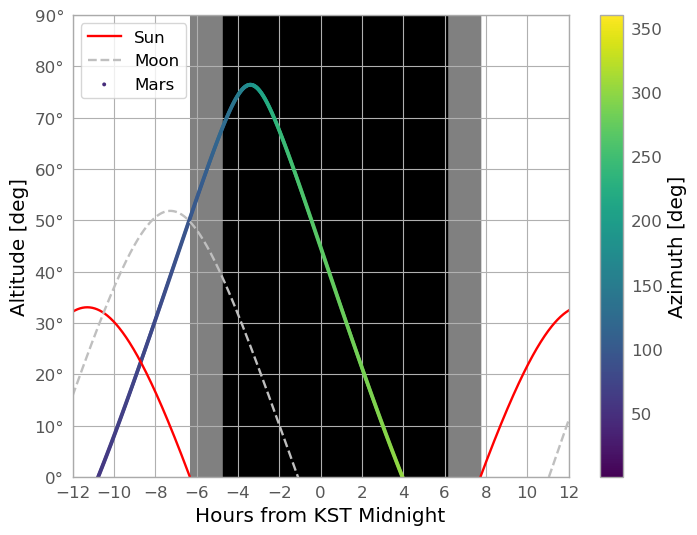

In [191]:
plt.plot(delta_midnight_ckc2, sunaltazs_today.alt, color = 'r', label = 'Sun')
plt.plot(delta_midnight_ckc2, moonaltazs_today.alt, color = [0.75]*3, ls = '--', label = 'Moon')
plt.scatter(delta_midnight_ckc2, mars_today.alt,
            c = mars_today.az, 
            label = 'Mars',
            lw = 0,
            s = 8,
            cmap = 'viridis')

plt.fill_between(delta_midnight_ckc2, 0*u.deg, 90*u.deg,
                 sunaltazs_today.alt < -0*u.deg, color = '0.5', zorder = 0)
plt.fill_between(delta_midnight_ckc2, 0*u.deg, 90*u.deg,
                 sunaltazs_today.alt < -18*u.deg, color = 'k', zorder = 0)
plt.colorbar().set_label('Azimuth [deg]')
plt.legend(loc = 'upper left')
plt.xlim(-12*u.hour, 12*u.hour)
plt.xticks((np.arange(13)*2 - 12)*u.hour)
plt.ylim(0*u.deg, 90*u.deg)
plt.xlabel('Hours from KST Midnight')
plt.ylabel('Altitude [deg]')
plt.show()

In [198]:
max_time = Time('2023-1-27 00:00:00') + delta_midnight_ckc2[np.argmax(mars_today.alt)]
print(max_time)

2023-01-26 20:36:02.162
